In [128]:
from proxmin import nmf
from proxmin.utils import Traceback
from scipy.optimize import linear_sum_assignment
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
import time
from proxmin import operators as po
from functools import partial

In [129]:
data = np.load("hsc_stacked.npy")

In [130]:
redshifts = data['z_cl']

# Bin the cluster data by redshift
clusters1 = data[(redshifts > 0.1) & (redshifts < 0.2)]
clusters2 = data[(redshifts > 0.2) & (redshifts < 0.35)]
clusters3 = data[(redshifts > 0.35) & (redshifts < 0.5)]
clusters4 = data[(redshifts > 0.5) & (redshifts < 0.75)]
clusters5 = data[(redshifts > 0.75) & (redshifts < 1.2)]

In [131]:
num_radial_bins = 15

In [132]:
# Compute the average colors (and their variances) for a given redshift bin

def avg_colors(clusters):
    
    clusters = clusters[np.where(clusters['R'] > 0.01)]
    radii = np.array(clusters['R'])
    #radii = radii[np.where(radii > 0.01)]
    radial_bins = np.logspace(np.log10(np.amin(radii)), np.log10(np.amax(radii)), num_radial_bins + 1)
    print(radial_bins)
    widths = np.diff(radial_bins)

    # Arrays containing magnitude data in four different filters
    g = np.array(clusters['gmag_forced_cmodel'])
    r = np.array(clusters['rmag_forced_cmodel'])
    i = np.array(clusters['imag_forced_cmodel'])
    z = np.array(clusters['zmag_forced_cmodel'])

    # For each color g-r, r-i, and i-z: first, throw out data points that have magnitudes of "nan" or "inf" (pruning the
    # arrays of radii and magnitudes accordingly), then use scipy.binned_statistic to sort the data into radial bins and
    # compute the mean and variance (noise^2) of the color values in those bins

    radii_gr_pruned = radii[np.isfinite(g) & np.isfinite(r)]
    gr = g[np.isfinite(g) & np.isfinite(r)] - r[np.isfinite(g) & np.isfinite(r)]
    count_gr = binned_statistic(radii_gr_pruned, gr, 'count', radial_bins)[0]
    mean_gr = binned_statistic(radii_gr_pruned, gr, 'mean', radial_bins)[0]
    var_gr = binned_statistic(radii_gr_pruned, gr, np.var, radial_bins)[0]
    var_gr /= count_gr

    radii_ri_pruned = radii[np.isfinite(r) & np.isfinite(i)]
    ri = r[np.isfinite(r) & np.isfinite(i)] - i[np.isfinite(r) & np.isfinite(i)]
    count_ri = binned_statistic(radii_ri_pruned, ri, 'count', radial_bins)[0]
    mean_ri = binned_statistic(radii_ri_pruned, ri, 'mean', radial_bins)[0]
    var_ri = binned_statistic(radii_ri_pruned, ri, np.var, radial_bins)[0]
    var_ri /= count_ri

    radii_iz_pruned = radii[np.isfinite(i) & np.isfinite(z)]
    iz = i[np.isfinite(i) & np.isfinite(z)] - z[np.isfinite(i) & np.isfinite(z)]
    count_iz = binned_statistic(radii_iz_pruned, iz, 'count', radial_bins)[0]
    mean_iz = binned_statistic(radii_iz_pruned, iz, 'mean', radial_bins)[0]
    var_iz = binned_statistic(radii_iz_pruned, iz, np.var, radial_bins)[0]
    var_iz /= count_iz

    # Compute the mean and variance of the i magnitudes over the same radial bins as above
    radii_i_pruned = radii[np.isfinite(i)]
    count_i = binned_statistic(radii_i_pruned, i, 'count', radial_bins)[0]
    mean_i = binned_statistic(radii_i_pruned, i, 'mean', radial_bins)[0]
    var_i = binned_statistic(radii_i_pruned, i, np.var, radial_bins)[0]
    var_i /= count_i
    
    return (radial_bins, widths, (mean_gr, var_gr), (mean_ri, var_ri), (mean_iz, var_iz), (mean_i, var_i))

In [133]:
# Plot bar graphs for the average color data in a given redshift bin

def plot_profiles(clusters, z_bin_num):
    
    clusters_data = avg_colors(clusters)

    radial_bins = clusters_data[0]
    widths = clusters_data[1]
    
    # gr, ri, iz, and i are 2-tuples of the form (mean_color, var_color)
    gr = clusters_data[2]
    ri = clusters_data[3]
    iz = clusters_data[4]
    i = clusters_data[5]
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")

    plt.bar(radial_bins[:-1], gr[0], width=widths, fill=False, align="edge", yerr=np.sqrt(gr[1]))
    plt.xscale('log')
    plt.title("Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average g-r [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], ri[0], width=widths, fill=False, align="edge", yerr=np.sqrt(ri[1]))
    plt.xscale('log')
    plt.title("Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average r-i [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], iz[0], width=widths, fill=False, align="edge", yerr=np.sqrt(iz[1]))
    plt.xscale('log')
    plt.title("Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i-z [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], i[0], width=widths, fill=False, align="edge", yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Average i-filter Magnitude vs. Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i [magnitudes]")
    plt.show()

[ 0.03192141  0.04471033  0.06262298  0.08771212  0.12285292  0.17207245
  0.24101119  0.33756941  0.4728125   0.66223909  0.92755715  1.29917167
  1.81966905  2.54869738  3.56980208  5.        ]


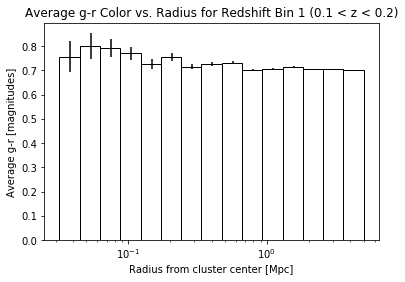

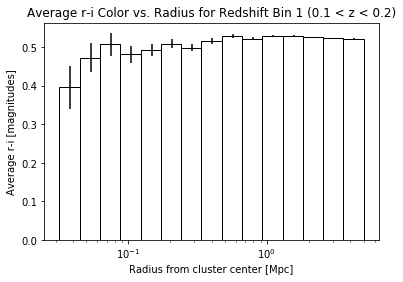

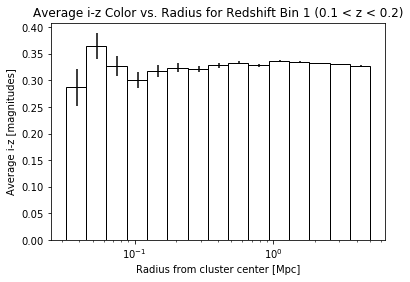

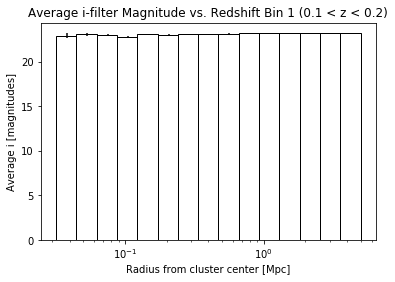

In [134]:
#Plot bar graphs for the clusters1 data

plot_profiles(clusters1, 1)

[ 0.01405449  0.0207918   0.03075878  0.04550363  0.06731673  0.0995864
  0.1473252   0.21794857  0.32242671  0.47698861  0.70564293  1.04390743
  1.544326    2.28463053  3.3798153   4.99999949]


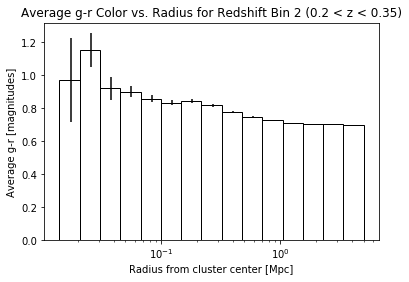

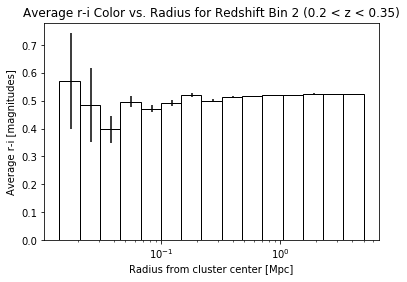

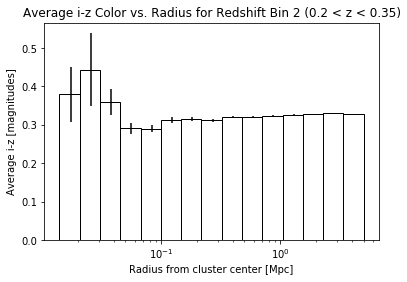

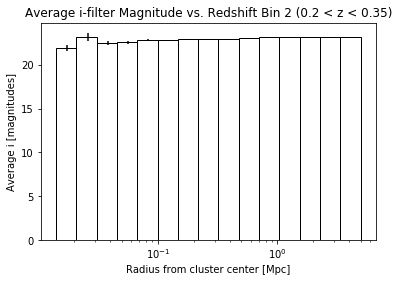

In [135]:
#Plot bar graphs for the clusters2 data

plot_profiles(clusters2, 2)

[ 0.01491097  0.02197202  0.03237683  0.0477088   0.0703012   0.10359218
  0.15264804  0.22493418  0.33145128  0.48840932  0.7196945   1.06050428
  1.5627038   2.30271881  3.39316633  4.99999293]


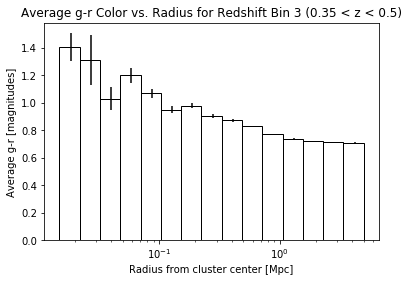

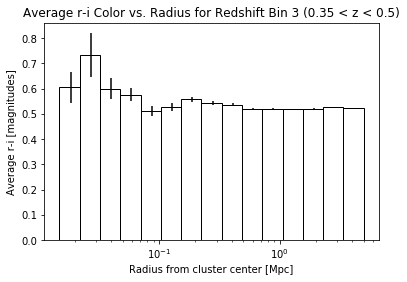

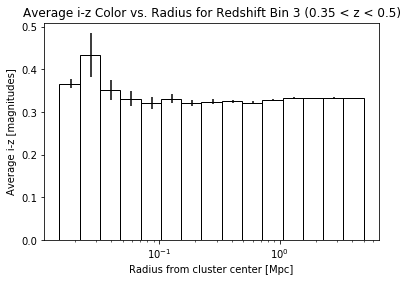

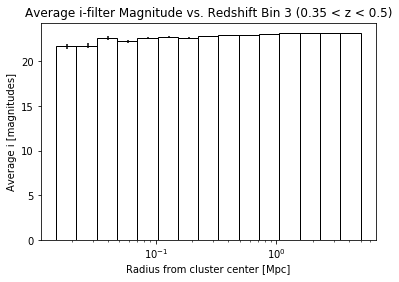

In [136]:
#Plot bar graphs for the clusters3 data

plot_profiles(clusters3, 3)

[ 0.01022369  0.01544893  0.02334475  0.03527606  0.05330535  0.08054927
  0.12171733  0.18392604  0.2779291   0.41997634  0.63462272  0.95897308
  1.44909619  2.18971712  3.3088632   4.99999546]


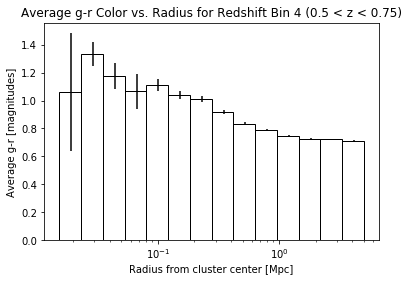

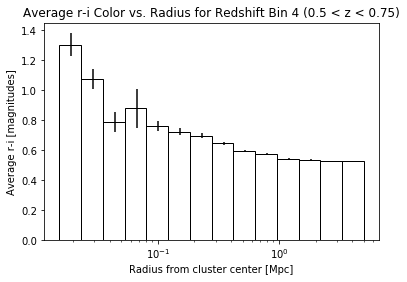

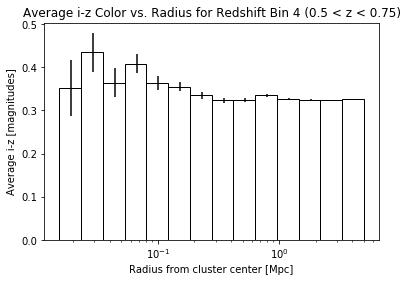

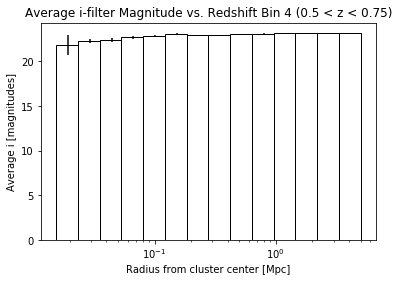

In [137]:
#Plot bar graphs for the clusters4 data

plot_profiles(clusters4, 4)

[ 0.01665267  0.02435844  0.03562995  0.05211719  0.07623365  0.11150964
  0.16310908  0.2385854   0.34898727  0.51047598  0.7466912   1.09221153
  1.59761628  2.33688962  3.41825077  4.99999583]


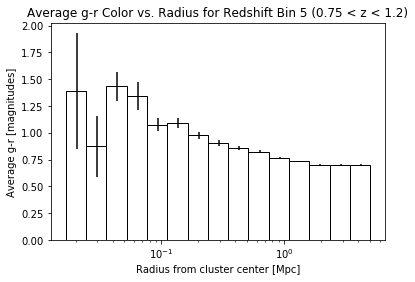

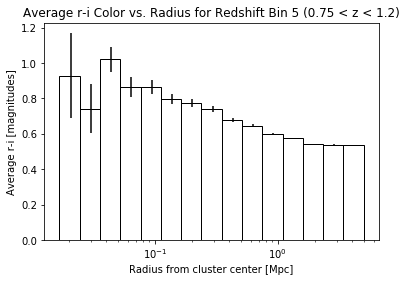

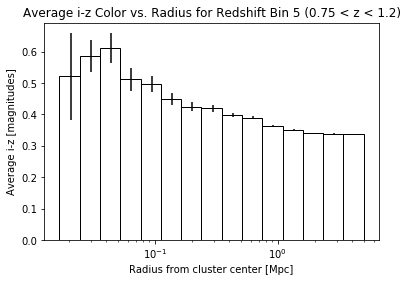

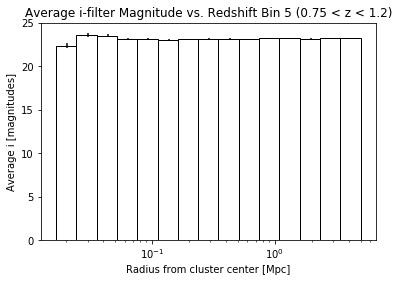

In [138]:
#Plot bar graphs for the clusters5 data

plot_profiles(clusters5, 5)

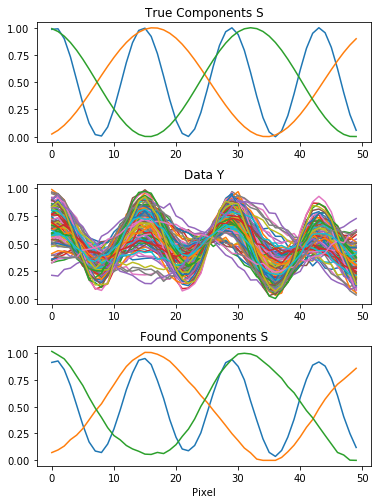

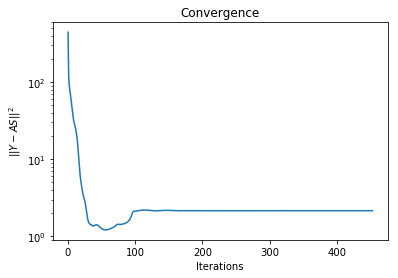

In [1]:
def match(A, S, trueS):
    """Rearranges columns of S to best fit the components they likely represent (maximizes sum of correlations)"""
    cov = np.cov(trueS, S)
    k = S.shape[0]
    corr = np.zeros([k,k])
    for i in range(k):
        for j in range(k):
            corr[i][j] = cov[i + k][j]/np.sqrt(cov[i + k][i + k]*cov[j][j])
    arrangement = linear_sum_assignment(-corr)
    resS = np.zeros_like(S)
    resAT = np.zeros_like(A.T)
    for t in range(k):
        resS[arrangement[1][t]] = S[arrangement[0][t]]
        resAT[arrangement[1][t]] = A.T[arrangement[0][t]]
    return resAT.T, resS

if __name__ == "__main__":
    n = num_radial_bins     # component resolution
    k = 3                   # number of components
    b = 4                   # number of observations (b=4 for g-r, r-i, i-z, and i)
    #noise = 0.02           # stdev of added noise

    # Data matrix to be unmixed
    Y = np.array([mean_gr_1, mean_ri_1, mean_iz_1, mean_i_1])
    
    # if noise is variable, specify variance matrix of the same shape as Y
    W = np.array([var_gr_1, var_ri_1, var_iz_1, var_i_1])

    # initialize and run NMF
    A = np.array([generateAmplitudes(k) for i in range(b)]) #???
    S = np.array([generateComponent(n) for i in range(k)])  #???
    p1 = partial(po.prox_unity_plus, axis=1)
    proxs_g=[[p1], None]
    tr = Traceback(2)
    nmf(Y, A, S, W=W, prox_A=p1, e_rel=1e-6, e_abs=1e-6/noise**2, traceback=tr)
    # sort components to best match inputs
    A, S = match(A, S, trueS)

    # show data and model
    fig = plt.figure(figsize=(6,7))
    ax = fig.add_subplot(311)
    ax.set_title("True Components S")
    ax.plot(trueS.T)
    ax2 = fig.add_subplot(312)
    ax2.set_title("Data Y")
    ax2.plot(Y.T)
    ax3 = fig.add_subplot(313)
    ax3.set_title("Found Components S")
    ax3.set_xlabel("Pixel")
    ax3.plot(S.T)
    fig.subplots_adjust(bottom=0.07, top=0.95, hspace=0.35)
    plt.show()

    # convergence plot from traceback
    #convergences = []
    #As = tr['X',0]
    #Ss = tr['X',1]
    #for it in range(tr.it):
    #    Y = np.dot(As[it], Ss[it])
    #    convergences.append(((Y - trueY)**2).sum())
    #fig2 = plt.figure(figsize=(6,4))
    #ax4 = fig2.add_subplot(111)
    #ax4.set_title("Convergence")
    #ax4.semilogy(convergences)
    #ax4.set_ylabel("$||Y-AS||^2$")
    #ax4.set_xlabel("Iterations")
    #plt.show()
